In [7]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

def plot_sensitivity_auto_fluid(
    run_folder: str,
    fold: int,
    test_csv: str,
    sample_index: int,
    total_propellant_vals: list[float],
    fluid_ratio_min: float = 0.4,
    fluid_ratio_max: float = 10.0,
    num_fluid_points: int = 10
):
    """
    For a saved run in `run_folder` (with {run_id}_fold{fold}.pth,
    {run_id}_hyperparams.json, {run_id}_norms.json), this:
      • picks row `sample_index` from `test_csv` as a baseline
      • ensures sample's Total.Proppant.Volume is in total_propellant_vals
      • for each propellant value, defines total_fluid_vals from
        [fluid_ratio_min * prop, ..., fluid_ratio_max * prop]
      • if prop == sample's propellant, inserts the actual sample's
        Total.Fluid into total_fluid_vals (so it falls between two points)
      • plots two subplots (one per output) of Output vs Total Fluid,
        with one curve per fluid type, and marks the actual sample point
    """
    # ─── Column headers ───────────────────────────────────────────────────────
    output_cols       = ["BOE_Prodoction_2 year cum", "BOE_Production_6mon cum"]
    gpi_col           = "GPI (gross perforated interval ft)"
    prop_per_gpi_col  = "Proppant.per.GPI..lb.ft."
    fluid_per_gpi_col = "Fluid.per.GPI..gal.ft."
    total_prop_col    = "Total.Proppant.Volume"
    total_fluid_col   = "Total.Fluid"
    fluid_type_col    = "Fluid.Type"

    # ─── Load hyperparams & norms ─────────────────────────────────────────────
    run_id     = os.path.basename(os.path.normpath(run_folder))
    hp = json.load(open(os.path.join(run_folder, f"{run_id}_hyperparams.json")))
    norms = json.load(open(os.path.join(run_folder, f"{run_id}_norms.json")))

    layer_dims, activations = hp["layer_dims"], hp["activations"]
    y_mean = np.array(norms["y_mean"], dtype=np.float32)
    y_std  = np.array(norms["y_std"],  dtype=np.float32)
    x_mean = norms["x_mean"]
    x_std  = norms["x_std"]

    # ─── Load test data & baseline sample ────────────────────────────────────
    df = pd.read_csv(test_csv)
    sample = df.iloc[sample_index]

    sample_propellant = float(sample[total_prop_col])
    sample_fluid     = float(sample[total_fluid_col])
    sample_type      = sample[fluid_type_col]
    y_true_sample    = sample[output_cols].to_numpy(dtype=np.float32).flatten()

    # ensure sample_propellant is in props, maintain sorted order
    props = sorted(set(total_propellant_vals + [sample_propellant]))

    # numeric & categorical feature names
    numeric_feats = list(x_mean.keys())
    fluid_types   = sorted(df[fluid_type_col].unique())
    dummy_feats   = [f"{fluid_type_col}_{ft}" for ft in fluid_types]

    # ─── Define & load the model ───────────────────────────────────────────────
    class MLPNet(nn.Module):
        def __init__(self, in_dim, hidden_dims, activations, out_dim):
            super().__init__()
            layers, dims = [], [in_dim] + hidden_dims
            for i, h in enumerate(hidden_dims):
                layers.append(nn.Linear(dims[i], dims[i+1]))
                act = activations[i].lower()
                if   act=='relu':     layers.append(nn.ReLU())
                elif act=='tanh':     layers.append(nn.Tanh())
                elif act=='sigmoid':  layers.append(nn.Sigmoid())
                elif act=='softplus': layers.append(nn.Softplus())
                else: raise ValueError(f"Unknown activation '{activations[i]}'")
            layers.append(nn.Linear(dims[-1], out_dim))
            self.net = nn.Sequential(*layers)
        def forward(self, x):
            return self.net(x)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MLPNet(
        in_dim      = len(numeric_feats) + len(dummy_feats),
        hidden_dims = layer_dims,
        activations = activations,
        out_dim     = len(output_cols)
    ).to(device)
    model.load_state_dict(torch.load(
        os.path.join(run_folder, f"{run_id}_fold{fold}.pth"),
        map_location=device
    ))
    model.eval()

    # prepare baseline features dict
    base_feats = {f: float(sample[f]) for f in numeric_feats}
    for d in dummy_feats:
        base_feats[d] = 0.0

    # ─── Sweep & plot ─────────────────────────────────────────────────────────
    for prop_val in props:
        # generate fluid sweep
        base_fluids = np.linspace(
            prop_val * fluid_ratio_min,
            prop_val * fluid_ratio_max,
            num_fluid_points
        ).tolist()

        # if this is the sample_propellant, insert sample_fluid
        if prop_val == sample_propellant:
            fluid_vals = sorted(set(base_fluids + [sample_fluid]))
        else:
            fluid_vals = base_fluids

        # collect predictions per fluid type & output
        preds = {ft: {0: [], 1: []} for ft in fluid_types}

        for ft in fluid_types:
            # set one-hot encoding
            for dft in dummy_feats:
                base_feats[dft] = 1.0 if dft == f"{fluid_type_col}_{ft}" else 0.0

            gpi = float(sample[gpi_col])

            for fluid_val in fluid_vals:
                # set swept inputs
                base_feats[total_prop_col]  = prop_val
                base_feats[total_fluid_col] = fluid_val
                base_feats[prop_per_gpi_col]  = prop_val  / gpi
                base_feats[fluid_per_gpi_col] = fluid_val / gpi

                # build normalized feature vector
                x_vec = [(base_feats[f] - x_mean[f]) / x_std[f] for f in numeric_feats]
                x_vec += [base_feats[d] for d in dummy_feats]

                X_in = torch.tensor([x_vec], dtype=torch.float32).to(device)
                with torch.no_grad():
                    y_pred_n = model(X_in).cpu().numpy().flatten()
                y_pred = y_pred_n * y_std + y_mean

                # store predictions
                for j in range(len(y_pred)):
                    preds[ft][j].append(float(y_pred[j]))

        # plotting
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        for j, ax in enumerate(axs):
            # plot each fluid-type curve and record color
            color_map = {}
            for ft in fluid_types:
                line, = ax.plot(
                    fluid_vals,
                    preds[ft][j],
                    label=str(ft)
                )
                color_map[ft] = line.get_color()

            # if this is the sample's propellant, mark the actual sample point
            if prop_val == sample_propellant:
                ax.scatter(
                    sample_fluid,
                    y_true_sample[j],
                    marker='X',
                    s=100,
                    color=color_map[sample_type],
                    edgecolor='k',
                    label=f"actual ({sample_type})"
                )

            ax.set_title(f"Output {j+1} vs Total Fluid\n(Total Propellant={prop_val:.0f})")
            ax.set_xlabel("Total Fluid")
            ax.set_ylabel(f"Output {j+1}")
            ax.legend()

        plt.tight_layout()
        plt.show()


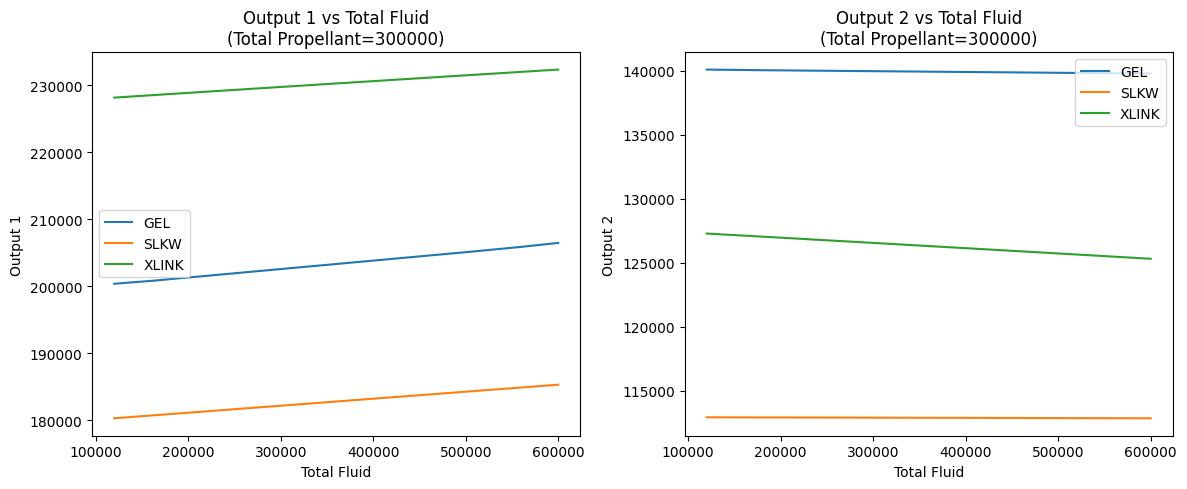

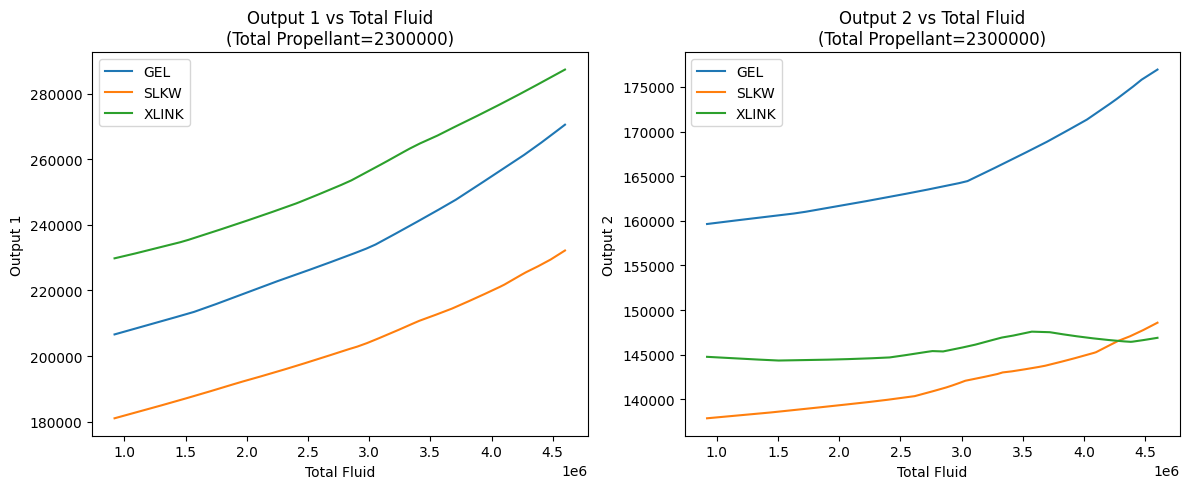

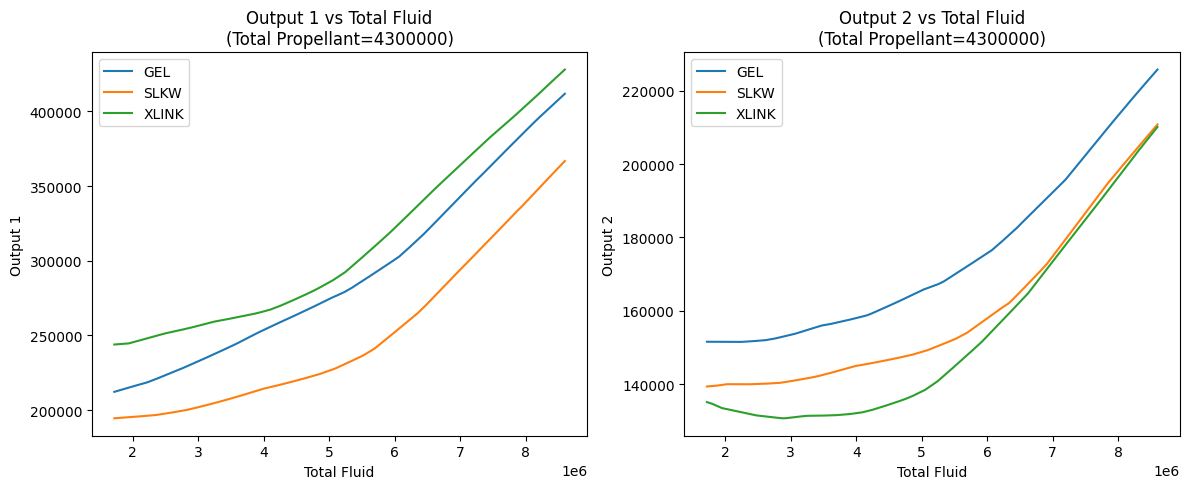

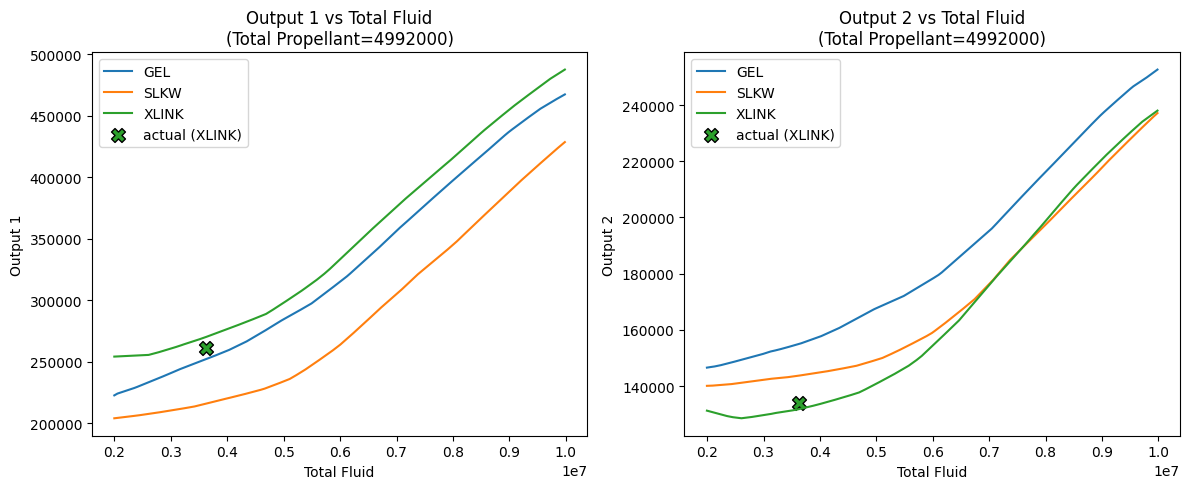

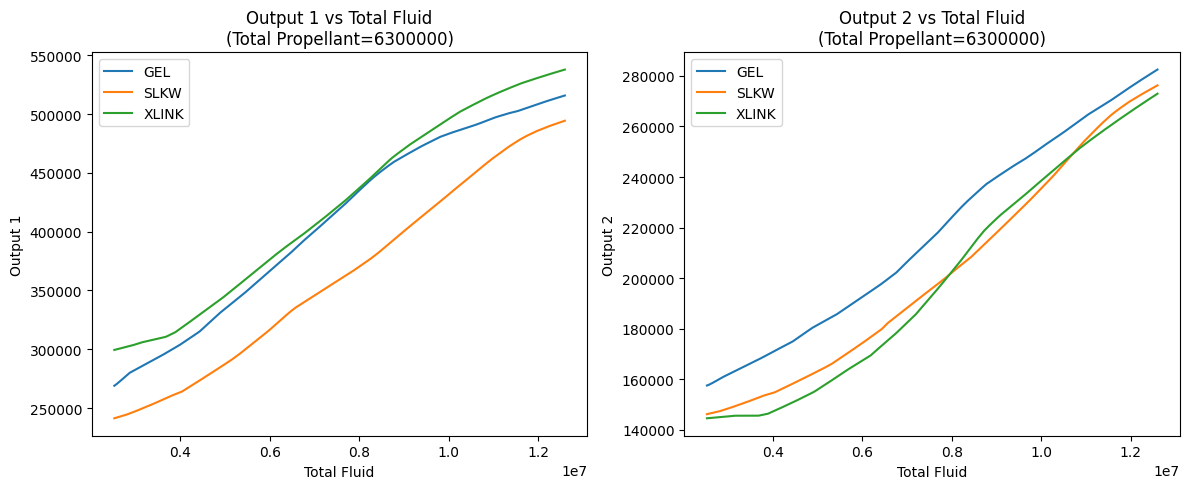

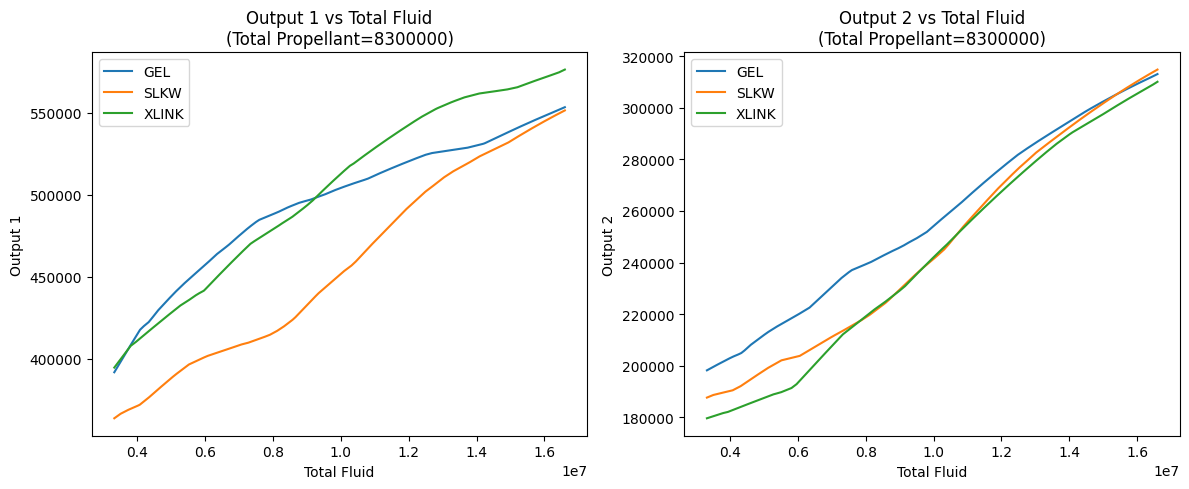

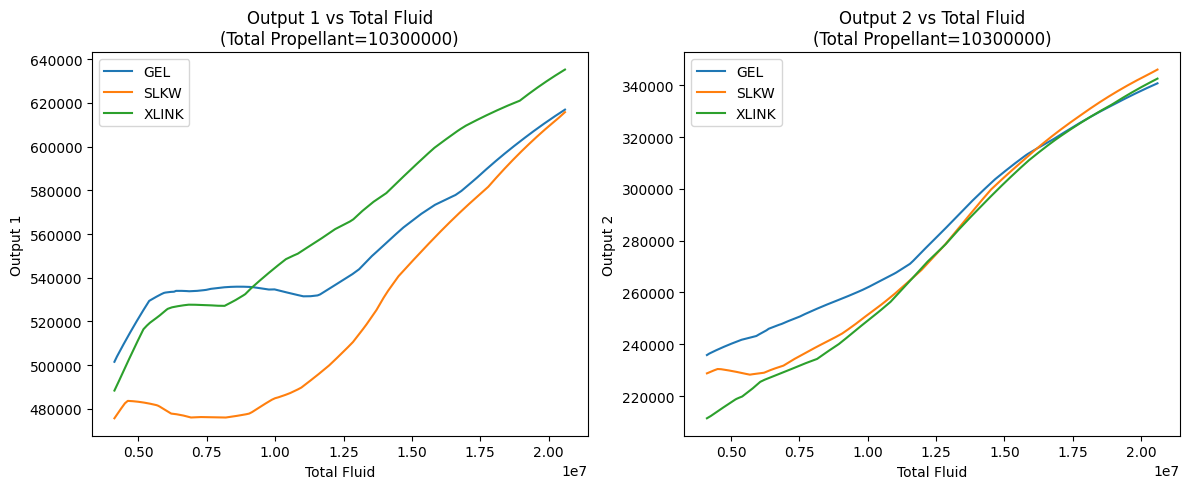

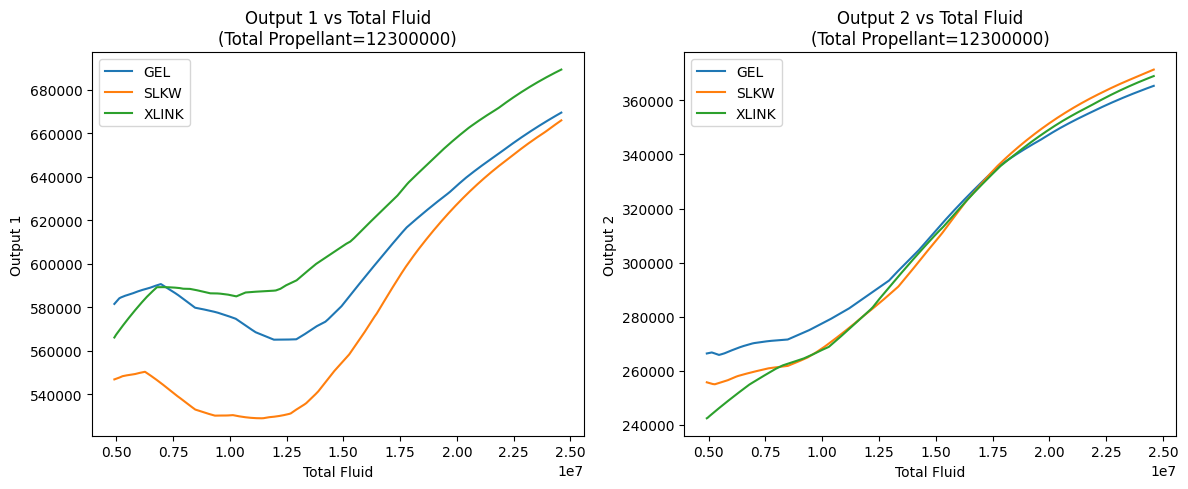

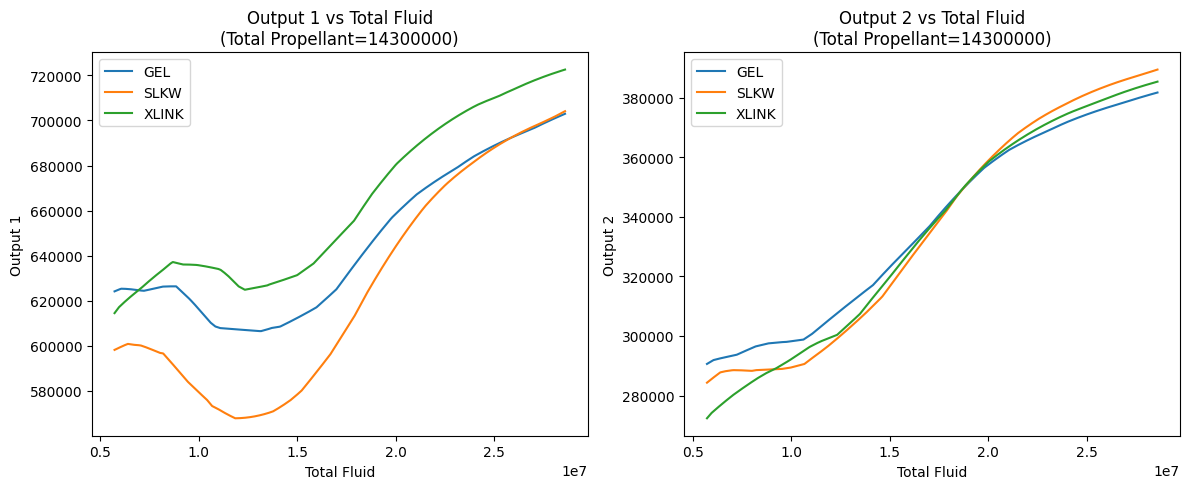

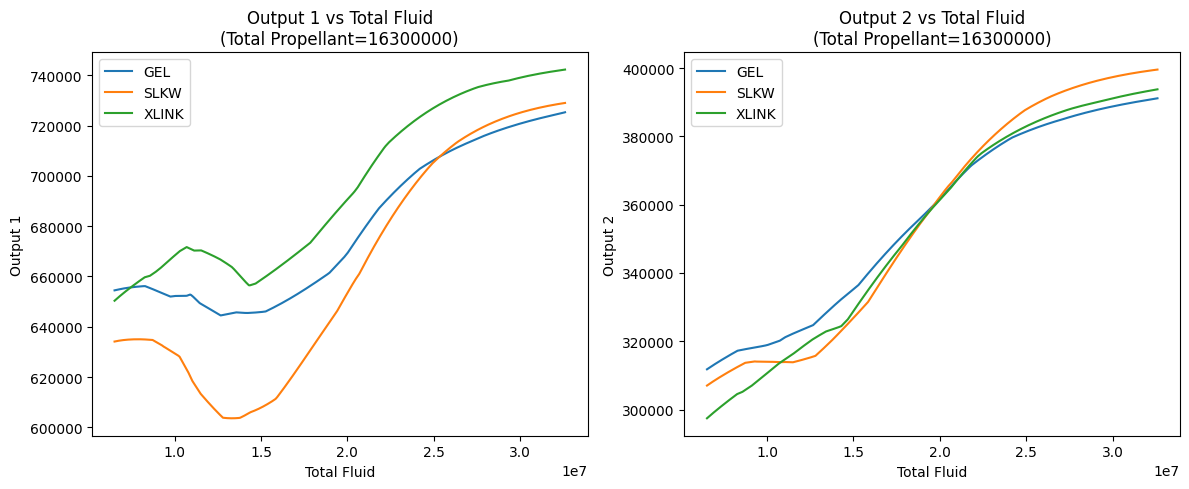

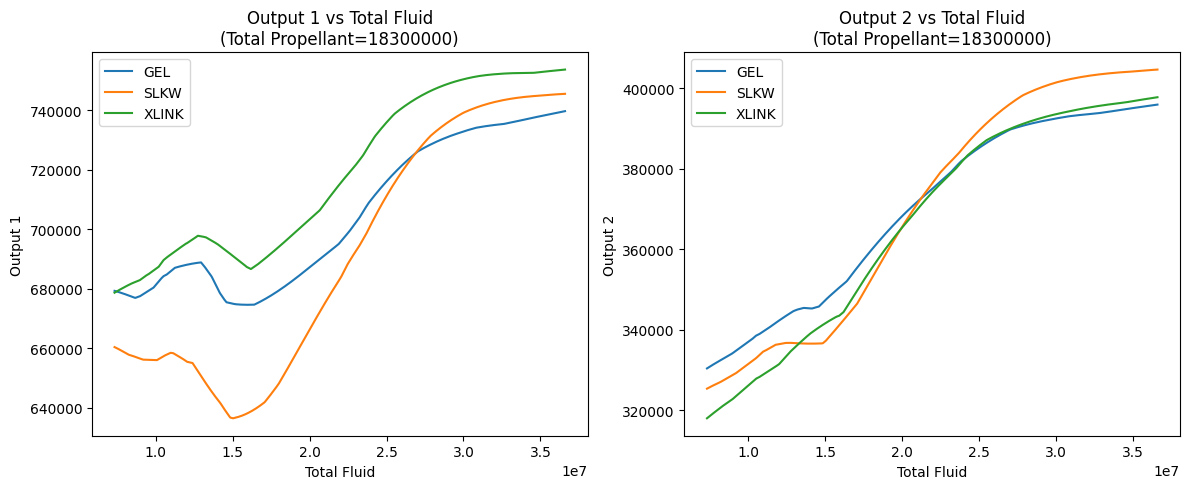

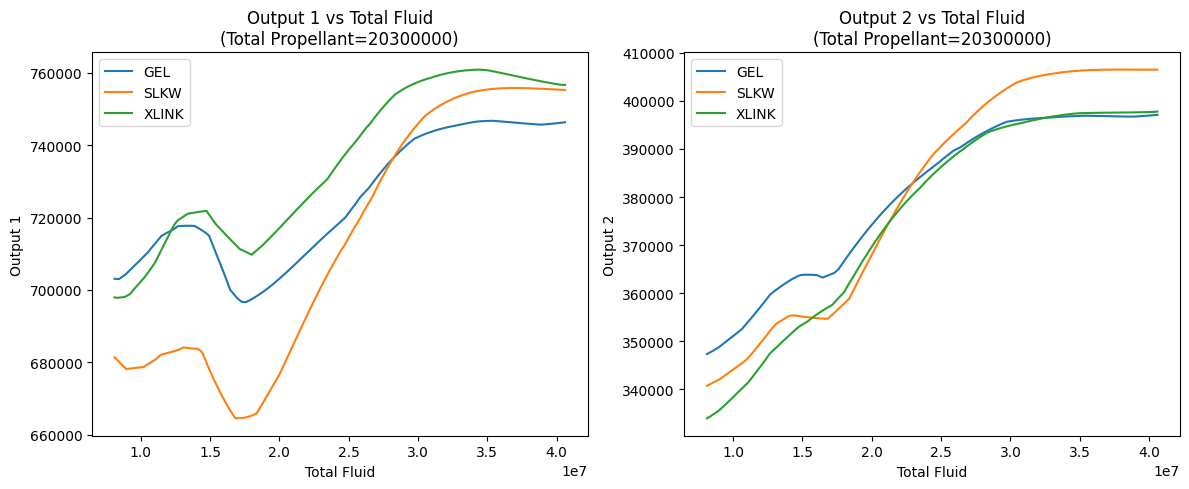

In [ ]:
plot_sensitivity_auto_fluid(
    run_folder="/home/kamiar/chevron/Eagle-Ford/First/606d04aa",
    fold=6,
    test_csv="/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    sample_index=0,
    total_propellant_vals = np.linspace(300_000, 20_300_000, num=11).tolist(),
    fluid_ratio_min= 0.4,
    fluid_ratio_max = 2,
    num_fluid_points = 1000
)

In [2]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def generate_sensitivity_report(
    run_folder: str,
    fold: int,
    test_csv: str,
    total_propellant_vals: list[float],
    fluid_ratio_min: float = 0.4,
    fluid_ratio_max: float = 10.0,
    num_fluid_points: int = 10,
    pdf_path: str = "sensitivity_report.pdf"
):
    """
    Generates a PDF report with:
      - For each sample:
        1) Title page “Sample <index>”
        2) One page per propellant value: a single subplot of
           Output 1 vs Total Fluid, curves per fluid type,
           actual sample marked.
    """
    # ─── Column headers ───────────────────────────────────────────────────────
    output_cols       = ["BOE_Prodoction_2 year cum", "BOE_Production_6mon cum"]
    gpi_col           = "GPI (gross perforated interval ft)"
    prop_per_gpi_col  = "Proppant.per.GPI..lb.ft."
    fluid_per_gpi_col = "Fluid.per.GPI..gal.ft."
    total_prop_col    = "Total.Proppant.Volume"
    total_fluid_col   = "Total.Fluid"
    fluid_type_col    = "Fluid.Type"

    # ─── Load hyperparams & norms ─────────────────────────────────────────────
    run_id     = os.path.basename(os.path.normpath(run_folder))
    with open(os.path.join(run_folder, f"{run_id}_hyperparams.json")) as f:
        hp = json.load(f)
    with open(os.path.join(run_folder, f"{run_id}_norms.json")) as f:
        norms = json.load(f)

    layer_dims, activations = hp["layer_dims"], hp["activations"]
    y_mean = np.array(norms["y_mean"], dtype=np.float32)
    y_std  = np.array(norms["y_std"],  dtype=np.float32)
    x_mean = norms["x_mean"]
    x_std  = norms["x_std"]

    # ─── Load test data ───────────────────────────────────────────────────────
    df = pd.read_csv(test_csv)
    numeric_feats = list(x_mean.keys())
    fluid_types   = sorted(df[fluid_type_col].unique())
    dummy_feats   = [f"{fluid_type_col}_{ft}" for ft in fluid_types]

    # ─── Define & load the trained MLP ────────────────────────────────────────
    class MLPNet(nn.Module):
        def __init__(self, in_dim, hidden_dims, activations, out_dim):
            super().__init__()
            layers, dims = [], [in_dim] + hidden_dims
            for i, h in enumerate(hidden_dims):
                layers.append(nn.Linear(dims[i], dims[i+1]))
                act = activations[i].lower()
                if   act=='relu':     layers.append(nn.ReLU())
                elif act=='tanh':     layers.append(nn.Tanh())
                elif act=='sigmoid':  layers.append(nn.Sigmoid())
                elif act=='softplus': layers.append(nn.Softplus())
                else: raise ValueError(f"Unknown activation '{activations[i]}'")
            layers.append(nn.Linear(dims[-1], out_dim))
            self.net = nn.Sequential(*layers)
        def forward(self, x):
            return self.net(x)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MLPNet(
        in_dim      = len(numeric_feats) + len(dummy_feats),
        hidden_dims = layer_dims,
        activations = activations,
        out_dim     = len(output_cols)
    ).to(device)
    model.load_state_dict(torch.load(
        os.path.join(run_folder, f"{run_id}_fold{fold}.pth"),
        map_location=device
    ))
    model.eval()

    # ─── Create PDF ───────────────────────────────────────────────────────────
    with PdfPages(pdf_path) as pdf:
        for sample_index, sample in df.iterrows():
            # 1) Title page
            fig, ax = plt.subplots(figsize=(11, 8.5))
            ax.axis('off')
            ax.text(0.5, 0.5, f"Sample {sample_index}", ha='center', va='center', fontsize=24)
            pdf.savefig(fig)
            plt.close(fig)

            # sample’s true values & metadata
            sample_propellant = float(sample[total_prop_col])
            sample_fluid      = float(sample[total_fluid_col])
            sample_type       = sample[fluid_type_col]
            y0_true           = float(sample[output_cols[0]])

            # ensure sample_propellant in props
            props = sorted(set(total_propellant_vals + [sample_propellant]))

            # baseline features
            base_feats = {f: float(sample[f]) for f in numeric_feats}
            for d in dummy_feats:
                base_feats[d] = 0.0

            # 2) For each propellant, plot Output1 vs Total Fluid
            for prop_val in props:
                # generate fluid sweep
                base_list = np.linspace(
                    prop_val * fluid_ratio_min,
                    prop_val * fluid_ratio_max,
                    num_fluid_points
                ).tolist()
                if prop_val == sample_propellant:
                    fluid_vals = sorted(set(base_list + [sample_fluid]))
                else:
                    fluid_vals = base_list

                # collect predictions for output 1
                preds = {ft: [] for ft in fluid_types}
                gpi = float(sample[gpi_col])

                for ft in fluid_types:
                    # set one-hot
                    for dft in dummy_feats:
                        base_feats[dft] = 1.0 if dft == f"{fluid_type_col}_{ft}" else 0.0

                    for fv in fluid_vals:
                        base_feats[total_prop_col]  = prop_val
                        base_feats[total_fluid_col] = fv
                        base_feats[prop_per_gpi_col]  = prop_val / gpi
                        base_feats[fluid_per_gpi_col] = fv / gpi

                        # build & normalize input
                        x_vec = [(base_feats[f] - x_mean[f]) / x_std[f] for f in numeric_feats]
                        x_vec += [base_feats[d] for d in dummy_feats]

                        X_in = torch.tensor([x_vec], dtype=torch.float32).to(device)
                        with torch.no_grad():
                            y_pred_n = model(X_in).cpu().numpy().flatten()
                        y_pred = y_pred_n * y_std + y_mean
                        preds[ft].append(float(y_pred[0]))

                # plot single subplot
                fig, ax = plt.subplots(figsize=(11, 5.5))
                color_map = {}
                for ft in fluid_types:
                    line, = ax.plot(fluid_vals, preds[ft], label=str(ft))
                    color_map[ft] = line.get_color()

                # mark actual sample
                if prop_val == sample_propellant:
                    ax.scatter(
                        sample_fluid, y0_true,
                        marker='X', s=100,
                        color=color_map[sample_type],
                        edgecolor='k',
                        label=f"actual ({sample_type})"
                    )

                ax.set_title(f"{output_cols[0]} vs Total Fluid\n(Total Propellant={prop_val:.0f})")
                ax.set_xlabel("Total Fluid")
                ax.set_ylabel(output_cols[0])
                ax.legend()
                plt.tight_layout()
                pdf.savefig(fig)
                plt.close(fig)

    print(f"PDF report saved to {pdf_path}")


In [3]:
generate_sensitivity_report(
    run_folder="/home/kamiar/chevron/Eagle-Ford/First/606d04aa",
    fold=6,
    test_csv="/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    total_propellant_vals = np.linspace(300_000, 20_300_000, num=11).tolist(),
    fluid_ratio_min=0.4,
    fluid_ratio_max=2,
    num_fluid_points=500,
    pdf_path="output1_sensitivity_report.pdf"
)


PDF report saved to output1_sensitivity_report.pdf
